# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [61]:
# import libraries
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import nltk


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB




In [62]:
# load data from database
engine = create_engine('sqlite:///DisastersProject.db')
df = pd.read_sql_table('Messages_Categories', engine)


In [63]:

X = df['message']
Y = df.drop(columns = ['id', 'message' , 'original' ,'genre'])



### 2. Write a tokenization function to process your text data

In [64]:
def tokenize(text):
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)
    return clean_tokens


### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [65]:

# Define the pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier()))
])



### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [66]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = pipeline.predict(X_test)


### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [67]:
#transforming to DF for use in the for loop
y_pred_df = pd.DataFrame(y_pred, columns=y_test.columns)

#Loop through columns and outputing results
for col_name, col_data in y_pred_df.items():
    report = classification_report(y_test.loc[:, col_name], col_data, zero_division=0)
    print('Category: {}\n{}'.format(col_name, report))

Category: related
              precision    recall  f1-score   support

           0       0.79      0.29      0.43      1246
           1       0.81      0.98      0.88      3948
           2       1.00      0.21      0.35        42

    accuracy                           0.81      5236
   macro avg       0.87      0.49      0.55      5236
weighted avg       0.81      0.81      0.77      5236

Category: request
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      4291
           1       0.90      0.39      0.55       945

    accuracy                           0.88      5236
   macro avg       0.89      0.69      0.74      5236
weighted avg       0.88      0.88      0.86      5236

Category: offer
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5211
           1       0.00      0.00      0.00        25

    accuracy                           1.00      5236
   macro avg       0.5

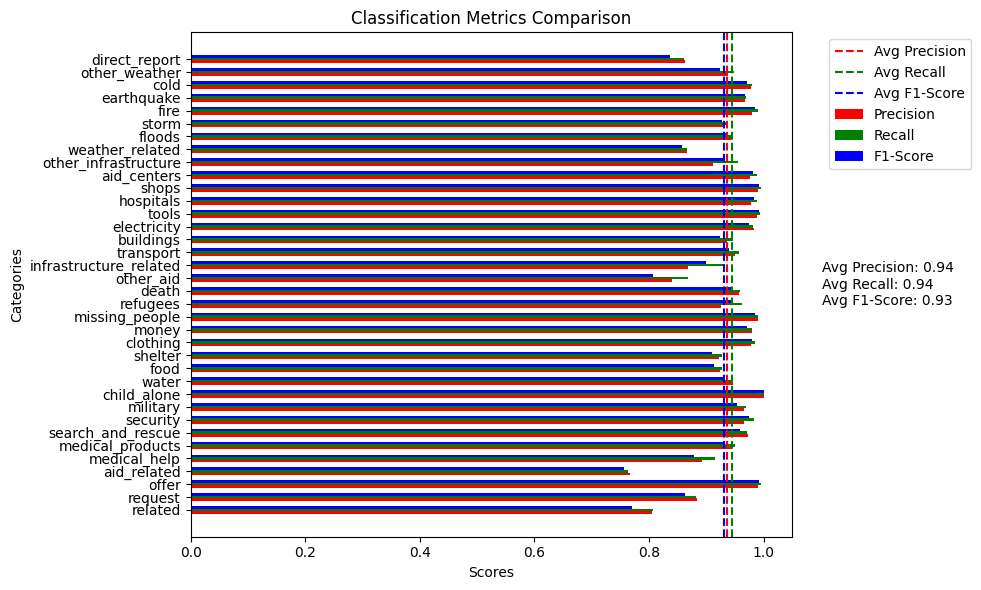

In [68]:
# Initialize empty lists to store metrics
precision_scores = []
recall_scores = []
f1_scores = []

# Loop through columns and accumulate metrics
for col_name, col_data in y_pred_df.items():
    report_dict = classification_report(y_test.loc[:, col_name], col_data, output_dict=True, zero_division=0)
    precision_scores.append(report_dict['weighted avg']['precision'])
    recall_scores.append(report_dict['weighted avg']['recall'])
    f1_scores.append(report_dict['weighted avg']['f1-score'])

# Calculate average scores
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)

# Create y-axis labels
categories = y_pred_df.columns

# Plotting the results
y = np.arange(len(categories))
height = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.barh(y - height, precision_scores, height, label='Precision', color='r')
rects2 = ax.barh(y, recall_scores, height, label='Recall', color='g')
rects3 = ax.barh(y + height, f1_scores, height, label='F1-Score', color='b')

# Add average score vertical lines
ax.axvline(avg_precision, color='r', linestyle='--', label='Avg Precision')
ax.axvline(avg_recall, color='g', linestyle='--', label='Avg Recall')
ax.axvline(avg_f1, color='b', linestyle='--', label='Avg F1-Score')

# Add labels, title, and legend
ax.set_xlabel('Scores')
ax.set_ylabel('Categories')
ax.set_title('Classification Metrics Comparison')
ax.set_yticks(y)
ax.set_yticklabels(categories)

# Move legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add note with average values
note = f'Avg Precision: {avg_precision:.2f}\nAvg Recall: {avg_recall:.2f}\nAvg F1-Score: {avg_f1:.2f}'
ax.text(1.05, 0.5, note, transform=ax.transAxes, ha='left', va='center')

# Display the plot
plt.tight_layout()
plt.show()


### 6. Improve your model
Use grid search to find better parameters. 

In [69]:
parameters = {
    'clf__estimator__n_estimators': [100, 200, 300],
    'clf__estimator__max_depth': [ 5, 10]
}


cv = GridSearchCV(pipeline, parameters, cv=5, scoring ="f1")


In [70]:
cv.fit(X_train, y_train)
Y_pred2 = cv.predict(X_test)


c:\Users\danil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\danil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\danil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\danil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
                        ^^

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [71]:
#transforming to DF for use in the for loop
Y_pred2_df = pd.DataFrame(Y_pred2, columns=y_test.columns)

#Loop through columns and outputing results
for col_name, col_data in Y_pred2_df.items():
    report = classification_report(y_test.loc[:, col_name], col_data,zero_division=0)
    print('Category: {}\n{}'.format(col_name, report))

Category: related
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1246
           1       0.75      1.00      0.86      3948
           2       0.00      0.00      0.00        42

    accuracy                           0.75      5236
   macro avg       0.25      0.33      0.29      5236
weighted avg       0.57      0.75      0.65      5236

Category: request
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      4291
           1       0.00      0.00      0.00       945

    accuracy                           0.82      5236
   macro avg       0.41      0.50      0.45      5236
weighted avg       0.67      0.82      0.74      5236

Category: offer
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5211
           1       0.00      0.00      0.00        25

    accuracy                           1.00      5236
   macro avg       0.5

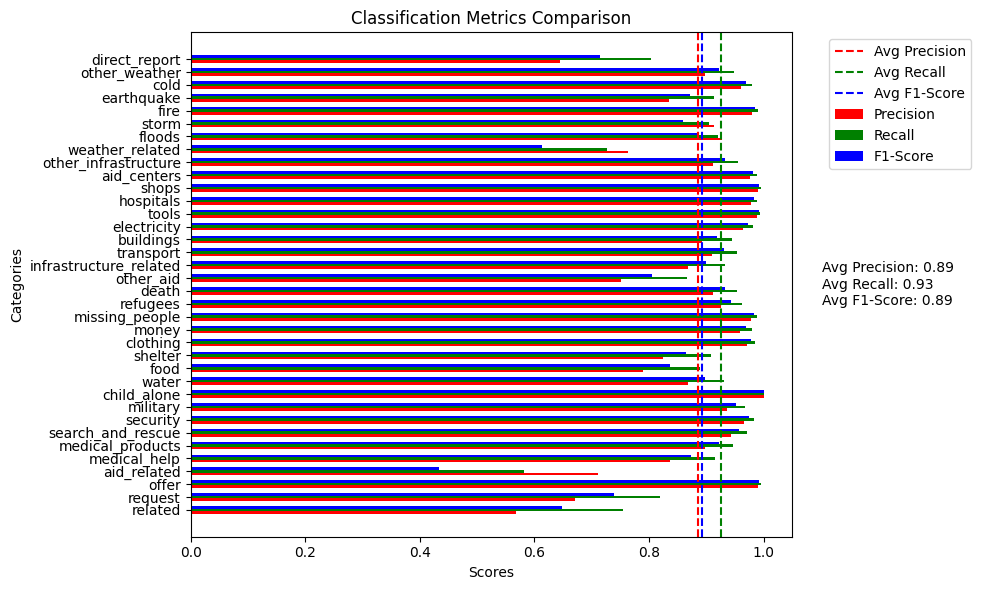

In [72]:
# Initialize empty lists to store metrics
precision_scores = []
recall_scores = []
f1_scores = []

# Loop through columns and accumulate metrics
for col_name, col_data in Y_pred2_df.items():
    report_dict = classification_report(y_test.loc[:, col_name], col_data, output_dict=True,zero_division=0)
    precision_scores.append(report_dict['weighted avg']['precision'])
    recall_scores.append(report_dict['weighted avg']['recall'])
    f1_scores.append(report_dict['weighted avg']['f1-score'])

# Calculate average scores
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)

# Create y-axis labels
categories = Y_pred2_df.columns

# Plotting the results
y = np.arange(len(categories))
height = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.barh(y - height, precision_scores, height, label='Precision', color='r')
rects2 = ax.barh(y, recall_scores, height, label='Recall', color='g')
rects3 = ax.barh(y + height, f1_scores, height, label='F1-Score', color='b')

# Add average score vertical lines
ax.axvline(avg_precision, color='r', linestyle='--', label='Avg Precision')
ax.axvline(avg_recall, color='g', linestyle='--', label='Avg Recall')
ax.axvline(avg_f1, color='b', linestyle='--', label='Avg F1-Score')

# Add labels, title, and legend
ax.set_xlabel('Scores')
ax.set_ylabel('Categories')
ax.set_title('Classification Metrics Comparison')
ax.set_yticks(y)
ax.set_yticklabels(categories)

# Move legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add note with average values
note = f'Avg Precision: {avg_precision:.2f}\nAvg Recall: {avg_recall:.2f}\nAvg F1-Score: {avg_f1:.2f}'
ax.text(1.05, 0.5, note, transform=ax.transAxes, ha='left', va='center')

# Display the plot
plt.tight_layout()
plt.show()


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [73]:
pipeline2 = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(MultinomialNB()))
])

# Fit the pipeline to the training data
pipeline2.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = pipeline.predict(X_test)

#transforming to DF for use in the for loop
y_pred_df_3 = pd.DataFrame(y_pred, columns=y_test.columns)

#Loop through columns and outputing results
for col_name, col_data in y_pred_df_3.items():
    report = classification_report(y_test.loc[:, col_name], col_data,zero_division=0)
    print('Category: {}\n{}'.format(col_name, report))

Category: related
              precision    recall  f1-score   support

           0       0.79      0.29      0.43      1246
           1       0.81      0.98      0.88      3948
           2       1.00      0.21      0.35        42

    accuracy                           0.81      5236
   macro avg       0.87      0.49      0.55      5236
weighted avg       0.81      0.81      0.77      5236

Category: request
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      4291
           1       0.90      0.39      0.55       945

    accuracy                           0.88      5236
   macro avg       0.89      0.69      0.74      5236
weighted avg       0.88      0.88      0.86      5236

Category: offer
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5211
           1       0.00      0.00      0.00        25

    accuracy                           1.00      5236
   macro avg       0.5

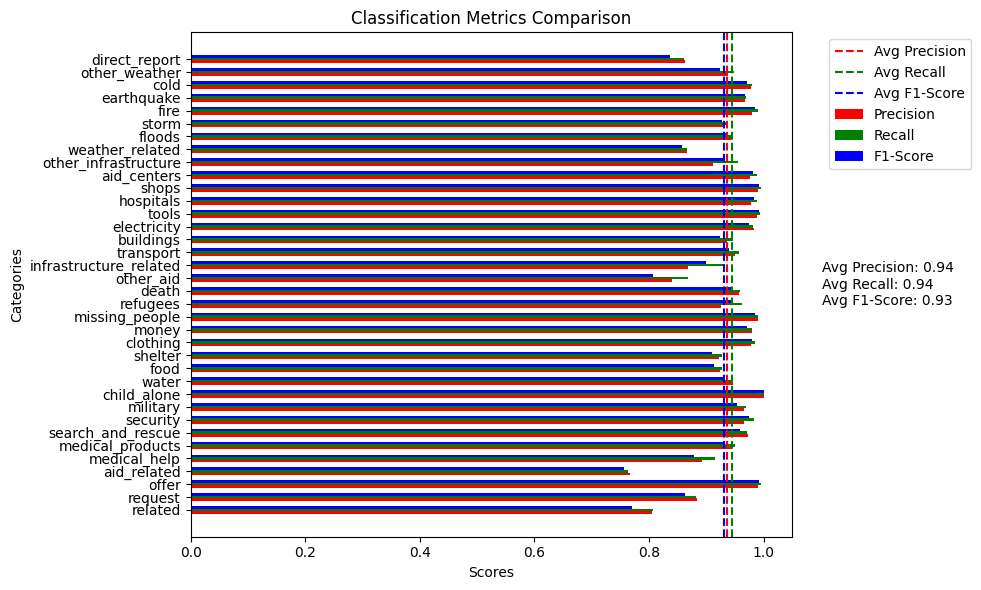

In [74]:
# Initialize empty lists to store metrics
precision_scores = []
recall_scores = []
f1_scores = []

# Loop through columns and accumulate metrics
for col_name, col_data in y_pred_df_3.items():
    report_dict = classification_report(y_test.loc[:, col_name], col_data, output_dict=True,zero_division=0)
    precision_scores.append(report_dict['weighted avg']['precision'])
    recall_scores.append(report_dict['weighted avg']['recall'])
    f1_scores.append(report_dict['weighted avg']['f1-score'])

# Calculate average scores
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)

# Create y-axis labels
categories = y_pred_df_3.columns

# Plotting the results
y = np.arange(len(categories))
height = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.barh(y - height, precision_scores, height, label='Precision', color='r')
rects2 = ax.barh(y, recall_scores, height, label='Recall', color='g')
rects3 = ax.barh(y + height, f1_scores, height, label='F1-Score', color='b')

# Add average score vertical lines
ax.axvline(avg_precision, color='r', linestyle='--', label='Avg Precision')
ax.axvline(avg_recall, color='g', linestyle='--', label='Avg Recall')
ax.axvline(avg_f1, color='b', linestyle='--', label='Avg F1-Score')

# Add labels, title, and legend
ax.set_xlabel('Scores')
ax.set_ylabel('Categories')
ax.set_title('Classification Metrics Comparison')
ax.set_yticks(y)
ax.set_yticklabels(categories)

# Move legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add note with average values
note = f'Avg Precision: {avg_precision:.2f}\nAvg Recall: {avg_recall:.2f}\nAvg F1-Score: {avg_f1:.2f}'
ax.text(1.05, 0.5, note, transform=ax.transAxes, ha='left', va='center')

# Display the plot
plt.tight_layout()
plt.show()


### 9. Export your model as a pickle file

In [75]:
filename = 'final_model.pkl'
pickle.dump(pipeline2, open(filename, 'wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.